(48, 48, 3)


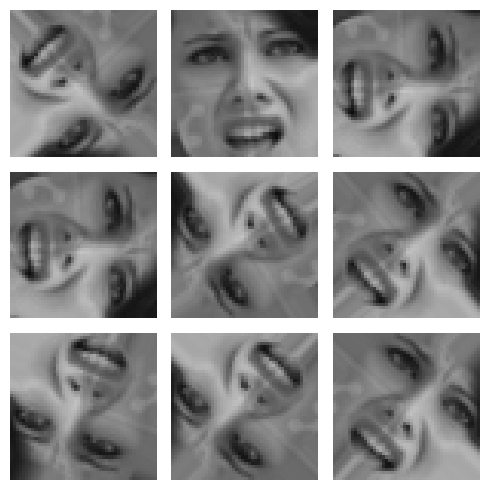

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img

img = load_img('533.jpg')
img_array = img_to_array(img)
print(img_array.shape)

# Load the image
img = load_img('533.jpg')

# Convert the image to a numpy array
img_array = img_to_array(img)

# Create an instance of the ImageDataGenerator class
datagen = ImageDataGenerator(rotation_range=180)

# Expand the dimensions of the numpy array
img_array = np.expand_dims(img_array, axis=0)

# Generate random rotated images
aug_iter = datagen.flow(img_array)

# Display 9 different rotated images
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(5,5))

# Rotate the image 9 times
for ax in axs.flatten():
    augmented_image = next(aug_iter)[0].astype('uint8')
    # Save the image with a unique filename
    save_img(f'533_rotated_{ax}.jpg', augmented_image)
    ax.imshow(augmented_image)
    ax.axis('off')
    
plt.tight_layout()
plt.show()

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
from tensorflow.keras import layers
from tensorflow.keras.models import Model

### NOISING DISGUST

In [2]:
def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.05
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return  np.clip(noisy_array, 0.0, 1.0)

def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (48, 48))
    return array

def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(48, 48))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(48, 48))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

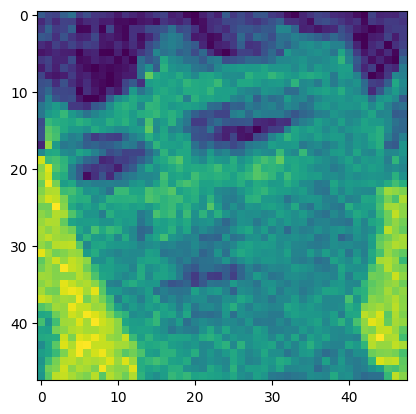

In [6]:
# Noising Disgust
# train_dir = '../datasets/train/'
# noise_dir = '../datasets/noised_train/'
# num_new_samples = 16
# np.random.seed(0)

# X_train = []
# Y_train = []
# for dir_name in os.listdir(train_dir):
#     for file_name in os.listdir(train_dir + dir_name):
#         img = np.array(Image.open(train_dir + dir_name + '/' + file_name))
#         for i in range(num_new_samples):
#             noise_img = noise(preprocess(img))
#             X_train.append(noise_img)
#             Y_train.append(preprocess(img))

# X_train = np.array(X_train)
# Y_train = np.array(Y_train)
# plt.imshow(X_train[0])
        # cv2.imwrite(noise_dir+str(i)+file_name, (noise_img*255).astype('int32'))
# Noising Disgust
train_dir = '../datasets/train/disgust/'
num_new_samples = 16
np.random.seed(0)

X_train = []
Y_train = []
for file_name in os.listdir(train_dir):
    img = np.array(Image.open(train_dir + file_name))
    for i in range(num_new_samples):
        noise_img = noise(preprocess(img))
        X_train.append(noise_img)
        Y_train.append(preprocess(img))

X_train = np.array(X_train)
Y_train = np.array(Y_train)
plt.imshow(X_train[0])


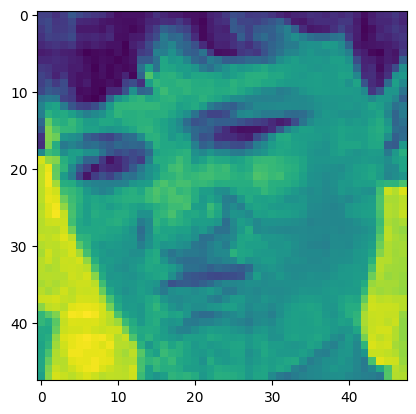

In [7]:

plt.imshow(Y_train[0])

In [8]:
input = layers.Input(shape=(48,48,1))
# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
intermediate = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(intermediate)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 24, 24, 32)       9248  

In [10]:
autoencoder.fit(
    x=X_train,
    y=Y_train,
    epochs=15,
    batch_size=128,
    shuffle=True,
    validation_data=(X_train, Y_train),
)

Epoch 1/15
55/55 [==============================] - 2s 43ms/step - loss: 0.5627 - val_loss: 0.5624
Epoch 2/15
55/55 [==============================] - 2s 41ms/step - loss: 0.5625 - val_loss: 0.5623
Epoch 3/15
55/55 [==============================] - 2s 41ms/step - loss: 0.5622 - val_loss: 0.5622
Epoch 4/15
55/55 [==============================] - 2s 41ms/step - loss: 0.5622 - val_loss: 0.5627
Epoch 5/15
55/55 [==============================] - 2s 41ms/step - loss: 0.5621 - val_loss: 0.5619
Epoch 6/15
55/55 [==============================] - 2s 41ms/step - loss: 0.5619 - val_loss: 0.5618
Epoch 7/15
55/55 [==============================] - 2s 41ms/step - loss: 0.5619 - val_loss: 0.5617
Epoch 8/15
55/55 [==============================] - 2s 41ms/step - loss: 0.5617 - val_loss: 0.5616
Epoch 9/15
55/55 [==============================] - 2s 41ms/step - loss: 0.5616 - val_loss: 0.5615
Epoch 10/15
55/55 [==============================] - 2s 41ms/step - loss: 0.5615 - val_loss: 0.5614
Epoch 11/

218/218 [==============================] - 1s 3ms/step


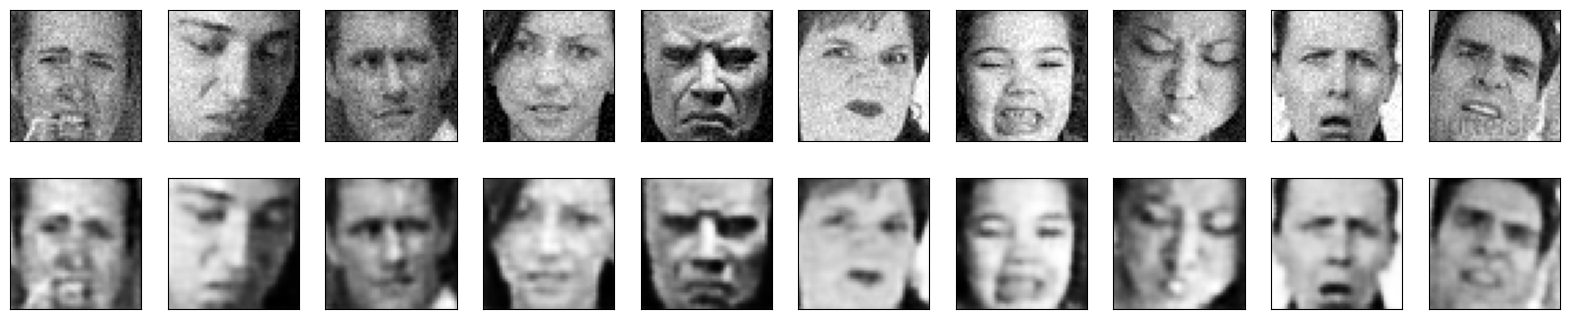

In [11]:
predictions = autoencoder.predict(X_train)
display(X_train, predictions)

In [20]:
for i, img_tensor in enumerate(predictions):
    cv2.imwrite('../datasets/augmented_train/disgust/'+str(i)+file_name, (img_tensor*255).astype('int32'))

### REDIMENSIONING, N